In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('~/Downloads/Conferences/Combined_CSV/ACC_combined/uvacombined.csv')
print(data.columns)


Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


/var/folders/y7/ptqmbdxx7sd_k5_4ynr96zg00000gn/T/ipykernel_40975/418856724.py:6: DtypeWarning:

Columns (27,93) have mixed types. Specify dtype option on import or set low_memory=False.



In [9]:
filtered_df = data[data['Batter'].str.contains('Ford, Henry', na=False)]
filtered_df.head()

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
8667,32,2024-02-16,15:21:54.50,4,1,"O'Hanlon, Michael",1.000061e+09,Right,HOF_PRI,"Ford, Henry",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
8668,33,2024-02-16,15:22:16.22,4,2,"O'Hanlon, Michael",1.000061e+09,Right,HOF_PRI,"Ford, Henry",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
8669,34,2024-02-16,15:22:37.55,4,3,"O'Hanlon, Michael",1.000061e+09,Right,HOF_PRI,"Ford, Henry",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
8670,35,2024-02-16,15:23:06.76,4,4,"O'Hanlon, Michael",1.000061e+09,Right,HOF_PRI,"Ford, Henry",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
8671,36,2024-02-16,15:23:28.39,4,5,"O'Hanlon, Michael",1.000061e+09,Right,HOF_PRI,"Ford, Henry",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN


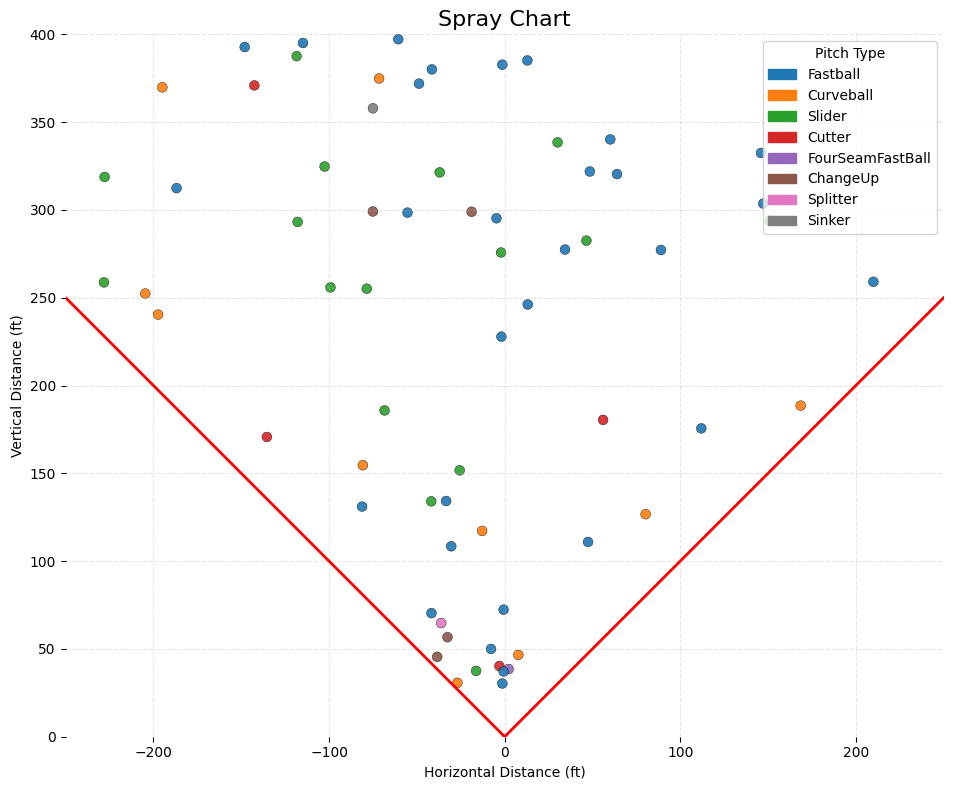

In [10]:
from matplotlib.patches import Patch
fair_data = filtered_df[
    (filtered_df['Direction'] >= -45) &
    (filtered_df['Direction'] <= 45) &
     (filtered_df['Distance'] >= 30)
].dropna(subset=['Distance'])

fair_data['Direction_rad'] = np.deg2rad(fair_data['Direction'])
fair_data['SprayX'] = fair_data['Distance'] * np.sin(fair_data['Direction_rad'])
fair_data['SprayY'] = fair_data['Distance'] * np.cos(fair_data['Direction_rad'])

pitch_types = fair_data['TaggedPitchType'].unique()
palette = dict(zip(pitch_types, sns.color_palette(n_colors=len(pitch_types))))
colors = fair_data['TaggedPitchType'].map(palette)

fig, ax = plt.subplots(figsize=(12, 8))

outfield = plt.Circle((0, 0), 250, color='white', fill=True, zorder=0)
ax.add_artist(outfield)
ax.plot([0, -250], [0, 250], color='red', linewidth=2)  # Left foul line
ax.plot([0, 250], [0, 250], color='red', linewidth=2)   # Right foul line

ax.scatter(
    fair_data['SprayX'], 
    fair_data['SprayY'], 
    color= colors, 
    alpha=0.9, 
    edgecolor='black', 
    linewidth=0.3,
    s=50
)

ax.set_xlim(-250, 250)
ax.set_ylim(0, 400)
ax.set_aspect('equal')
ax.set_facecolor('white')
sns.despine(left=True, bottom=True)

legend_handles = [Patch(color=palette[p], label=p) for p in pitch_types]
ax.legend(handles=legend_handles, title='Pitch Type', loc='upper right')

plt.title('Spray Chart', fontsize=16)
plt.xlabel('Horizontal Distance (ft)')
plt.ylabel('Vertical Distance (ft)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
import plotly.graph_objects as go


fair_data['Direction_rad'] = np.deg2rad(fair_data['Direction'])
fair_data['SprayX'] = fair_data['Distance'] * np.sin(fair_data['Direction_rad'])
fair_data['SprayY'] = fair_data['Distance'] * np.cos(fair_data['Direction_rad'])

pitch_types = fair_data['TaggedPitchType'].unique()
palette = dict(zip(pitch_types, sns.color_palette("hsv", n_colors=len(pitch_types)).as_hex()))
fair_data['Color'] = fair_data['TaggedPitchType'].map(palette)

fig = go.Figure()

for pitch in pitch_types:
    df_subset = fair_data[fair_data['TaggedPitchType'] == pitch]
    fig.add_trace(go.Scatter(
        x=df_subset['SprayX'],
        y=df_subset['SprayY'],
        mode='markers',
        marker=dict(size=8, color=palette[pitch], line=dict(width=0.5, color='black')),
        name=pitch,
        hovertemplate=f"<b>{pitch}</b><br>X: %{{x}}<br>Y: %{{y}}<extra></extra>"
    ))


fig.add_shape(type="line", x0=0, y0=0, x1=-250, y1=250, line=dict(color="red", width=2))
fig.add_shape(type="line", x0=0, y0=0, x1=250, y1=250, line=dict(color="red", width=2))

theta = np.linspace(-np.pi/4, np.pi/4, 200)
arc_x = 250 * np.sin(theta)
arc_y = 250 * np.cos(theta)
fig.add_trace(go.Scatter(x=arc_x, y=arc_y, mode='lines', line=dict(color='lightgray'), showlegend=False))

# Layout adjustments
fig.update_layout(
    title="Spray Chart (Interactive)",
    xaxis=dict(title="Horizontal Distance (ft)", range=[-250, 250], showgrid=True),
    yaxis=dict(title="Vertical Distance (ft)", range=[0, 400], showgrid=True),
    width=800,
    height=700,
    plot_bgcolor='white',
    legend_title_text='Pitch Type'
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()


In [ ]:
import plotly.graph_objects as go

fair_data = data[
    (data['Direction'] >= -45) &
    (data['Direction'] <= 45) &
     (data['Distance'] >= 30)
].dropna(subset=['Distance'])

fair_data['Direction_rad'] = np.deg2rad(fair_data['Direction'])
fair_data['SprayX'] = fair_data['Distance'] * np.sin(fair_data['Direction_rad'])
fair_data['SprayY'] = fair_data['Distance'] * np.cos(fair_data['Direction_rad'])


selected_batters = ['Nunalee, James', 'Sirois, Jackson', 'Buchanan, Walker']
subset_data = fair_data[fair_data['Batter'].isin(selected_batters)]
batters = subset_data['Batter'].unique()


pitch_types = fair_data['TaggedPitchType'].unique()
palette = dict(zip(pitch_types, sns.color_palette("hsv", n_colors=len(pitch_types)).as_hex()))
fair_data['Color'] = fair_data['TaggedPitchType'].map(palette)

fig = go.Figure()

# Add a trace for each batter, initially visible=False except the first
for i, batter in enumerate(batters):
    batter_data = fair_data[fair_data['Batter'] == batter]
    fig.add_trace(go.Scatter(
        x=batter_data['SprayX'],
        y=batter_data['SprayY'],
        mode='markers',
        marker=dict(size=8, color='blue', line=dict(width=1, color='black')),
        name=batter,
        visible=(i == 0),
        hovertemplate=(
            f"Batter: {batter}<br>" +
            "Distance: %{customdata[0]} ft<br>" +
            "Pitch Type: %{customdata[1]}"
        ),
        customdata=np.stack((batter_data['Distance'], batter_data['TaggedPitchType']), axis=-1)
    ))

# Dropdown menu
dropdown_buttons = [
    dict(
        label=batter,
        method='update',
        args=[
            {"visible": [i == j for j in range(len(batters))]},
            {"title": f"Spray Chart for {batter}"}
        ]
    )
    for i, batter in enumerate(batters)
]

# Foul lines as shapes
foul_lines = [
    dict(type="line", x0=0, y0=0, x1=-250, y1=250, line=dict(color="red", width=2)),
    dict(type="line", x0=0, y0=0, x1=250, y1=250, line=dict(color="red", width=2))
]

# Layout update
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            x=0.05,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ],
    shapes=foul_lines,
    title=f"Spray Chart",
    xaxis=dict(range=[-250, 250], title='Horizontal Distance (ft)'),
    yaxis=dict(range=[0, 400], title='Vertical Distance (ft)', scaleanchor='x'),
    plot_bgcolor='white',
    width=900,
    height=700
)

fig.show()